# [GIS] Uber h3와 kepler.gl을 활용한 공간분석

[yg's blog](https://yganalyst.github.io/spatial_analysis/uber_h3_keplergl/)에 포스팅한 내용의 source code입니다.  

---

In [28]:
import h3
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, Point, mapping
from shapely.ops import unary_union
from fiona.crs import from_string
epsg4326 = from_string("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

import matplotlib.pyplot as plt

## h3 basic function  

In [2]:
df = pd.read_csv("dataset/"+"train.csv")
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


먼저 택시 데이터에서 sample point하나만 가져오고, 해상도(resolution)는 8로 설정하자.  


In [3]:
point = df.iloc[0][["pickup_latitude","pickup_longitude"]].values
res = 8

- `h3.geo_to_h3`: 좌표를 h3 index로 변환  

In [4]:
point_h3 = h3.geo_to_h3(point[0], point[1], res)
print(point_h3)

882a1008b3fffff


- `h3.h3_to_geo_boundary`: h3의 boundary 좌표 출력  

In [5]:
h3_bnd = h3.h3_to_geo_boundary(point_h3, geo_json=True)
print(h3_bnd)

((-73.98458981348507, 40.77551579030846), (-73.99097256583582, 40.77446168130402), (-73.99293836780527, 40.77000081157416), (-73.98852232840895, 40.766594382212254), (-73.98214060271079, 40.76764827116326), (-73.98017388986867, 40.77210880949959), (-73.98458981348507, 40.77551579030846))


- `h3.h3_to_geo`: h3의 중심(centroid) 좌표 출력  

In [6]:
h3_point = h3.h3_to_geo(point_h3)
print(h3_point)

(40.77105498201156, -73.98655625625548)


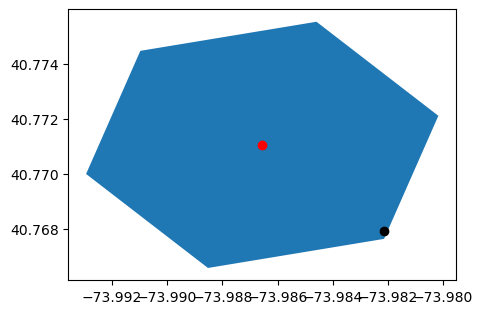

In [7]:
ax = gpd.GeoSeries(Polygon(h3_bnd)).plot(figsize=(5,5))
gpd.GeoSeries(Point(h3_point[1], h3_point[0])).plot(ax=ax, color='red')
gpd.GeoSeries(Point(point[1], point[0])).plot(ax=ax, color='black')
plt.show()

- `to_polygon` 함수 생성  

위에서 plot한것 처럼 `h3_to_geo_boundary`를 통해 Polygon을 만들었다.  
이를 아래와 같이 함수로 저장해놓고 사용하면 간편하다.  

In [8]:
def to_polygon(l):
    return Polygon(h3.h3_to_geo_boundary(l, geo_json=True))

- `h3.k_ring`: h3의 neighbor h3들 가져오기  

In [9]:
neighbor_h3 = h3.k_ring(point_h3)
print(neighbor_h3)

{'882a1008b7fffff', '882a1008bbfffff', '882a107259fffff', '882a100d6dfffff', '882a100d65fffff', '882a1008b1fffff', '882a1008b3fffff'}


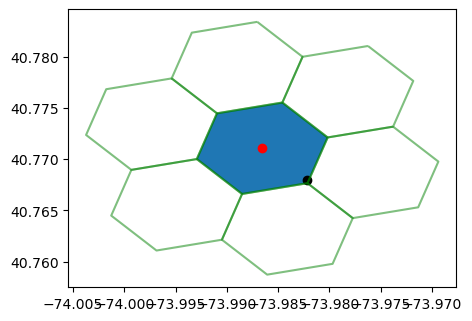

In [10]:
ax = gpd.GeoSeries(Polygon(h3_bnd)).plot(figsize=(5,5))
for h in neighbor_h3:
    gpd.GeoSeries(to_polygon(h).boundary).plot(ax=ax, color='green', alpha=.5)
gpd.GeoSeries(Point(h3_point[1],h3_point[0])).plot(ax=ax, color='red')
gpd.GeoSeries(Point(point[1], point[0])).plot(ax=ax, color='black')
plt.show()

- `h3.h3_indexes_are_neighbors`: neighbor h3인지 판단하기  

In [11]:
for h in neighbor_h3:
    cond = h3.h3_indexes_are_neighbors(point_h3, h)
    print(h,cond)

882a1008b7fffff True
882a1008bbfffff True
882a107259fffff True
882a100d6dfffff True
882a100d65fffff True
882a1008b1fffff True
882a1008b3fffff False


- `h3.h3_distance`: h3 index간의 거리(칸) 계산  

In [12]:
point2 = df.iloc[1][["pickup_latitude","pickup_longitude"]].values
point2_h3 = h3.geo_to_h3(point2[0], point2[1], res)
point2_h3_bnd = to_polygon(point2_h3)

distance = h3.h3_distance(point_h3,point2_h3)
print(distance)

4


- `h3.k_ring_distance`: k내 거리에 있는 h3 index를 반환  

In [13]:
k_h3 = h3.k_ring_distances(point_h3,1)
print(k_h3)

[{'882a1008b3fffff'}, {'882a1008b7fffff', '882a1008b1fffff', '882a107259fffff', '882a100d6dfffff', '882a100d65fffff', '882a1008bbfffff'}]


이를 이용해서 `h3.h3_distance`로 구한 거리가 정말 4만큼 떨어져 있는지 확인해보자.  

In [14]:
k_h3_6 = h3.k_ring_distances(point_h3,4)
print(len(k_h3_6))

gs = []
for hier in k_h3_6:
    for h in hier:
        gs.append(to_polygon(h))

5


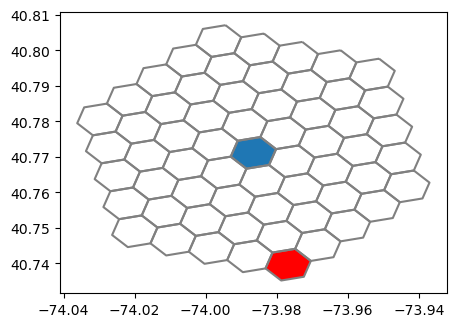

In [15]:
ax = gpd.GeoSeries(Polygon(h3_bnd)).plot(figsize=(5,5))
gpd.GeoSeries(gs).boundary.plot(ax=ax, color='grey')
gpd.GeoSeries(point2_h3_bnd).plot(ax=ax, color='red')
plt.show()

## h3.polyfill function  

- `h3.polyfill`: polygon 내부를 grid로 채우기  

In [20]:
nyc_bnd = gpd.GeoDataFrame.from_file("/data/newyork_bnd.shp")

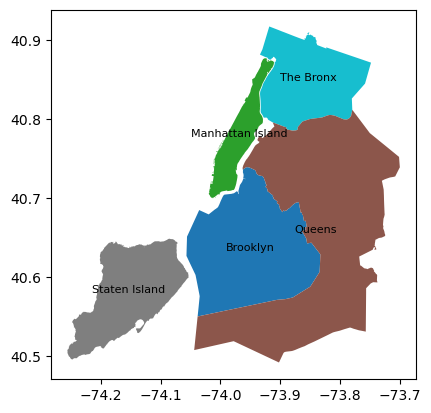

In [21]:
ax = nyc_bnd.plot(column='name')
for idx, row in nyc_bnd.iterrows():
    ax.annotate(text=row['name'], xy=row['geometry'].centroid.coords[0],
                 horizontalalignment='center', fontsize=8)
plt.show()

In [22]:
brooklyn = nyc_bnd[nyc_bnd["name"]=="Brooklyn"]

g = mapping(brooklyn["geometry"].iloc[0])
g['coordinates'] = [[[j[1],j[0]] for j in i] for i in g['coordinates']]  
hex_list = h3.polyfill(g,res=res)

print("*Resointion :",res)
print("*Number of hex :",len(hex_list))

*Resointion : 8
*Number of hex : 340


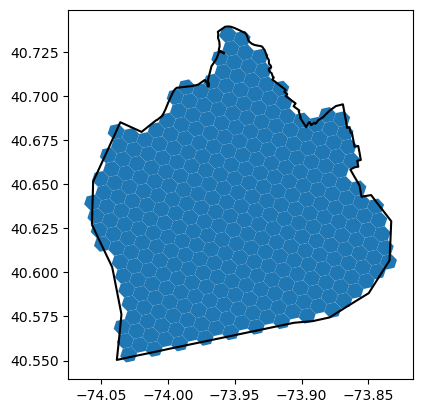

In [30]:
br_hex = pd.DataFrame(hex_list,columns=["hex_id"])
br_hex['geometry'] = br_hex["hex_id"].apply(lambda x : to_polygon(x))
br_hex = gpd.GeoDataFrame(br_hex, geometry='geometry', crs=epsg4326)

ax = br_hex.plot()
brooklyn.boundary.plot(ax=ax, color='black')
plt.show()

모든 자치구에 적용해보면 아래와 같은 결과를 뽑을 수 있다.  

In [25]:
nyc_hex=gpd.GeoDataFrame()
for r in nyc_bnd.iterrows():
    name = r[1]["name"]
    geom = r[1]["geometry"]
    g = mapping(geom)
    g['coordinates'] = [[[j[1],j[0]] for j in i] for i in g['coordinates']]  
    
    sub_df = gpd.GeoDataFrame({"name":name,
                               "hex_id":list(h3.polyfill(g,res=res))})
    nyc_hex = nyc_hex.append(sub_df, ignore_index=True)
    print(name,":",len(sub_df))
print("*Total:", len(nyc_hex))

The Bronx : 202
Brooklyn : 340
Queens : 627
Staten Island : 203
Manhattan Island : 74
*Total: 1446


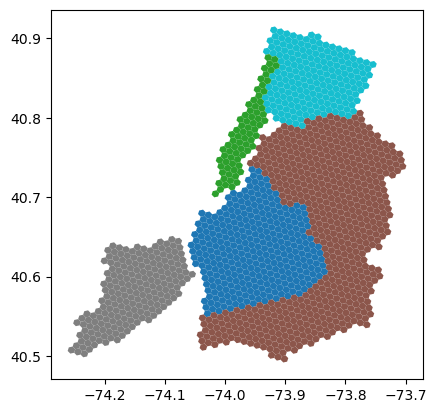

In [29]:
nyc_hex['geometry'] = nyc_hex["hex_id"].apply(lambda x : to_polygon(x))
nyc_hex = gpd.GeoDataFrame(nyc_hex, geometry='geometry', crs=epsg4326)

nyc_hex.plot(column="name")
plt.show()

## h3를 활용한 맨해튼 택시수요 시각화  

- basemap 만들기  

In [34]:
res2 = 9
manhattan = nyc_bnd[nyc_bnd["name"]=="Manhattan Island"]

g = mapping(manhattan["geometry"].iloc[0])
g['coordinates'] = [[[j[1],j[0]] for j in i] for i in g['coordinates']]  
manhattan_hex = gpd.GeoDataFrame({"hex_id":list(h3.polyfill(g,res=res2))}, crs=epsg4326)
manhattan_hex['geometry'] = manhattan_hex["hex_id"].apply(lambda x : to_polygon(x))
manhattan_hex = manhattan_hex.set_geometry("geometry")

print("*Resointion :",res2)
print("*Number of hex :",len(manhattan_hex))

*Resointion : 9
*Number of hex : 523


C:\Users\syg\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  


<AxesSubplot:>

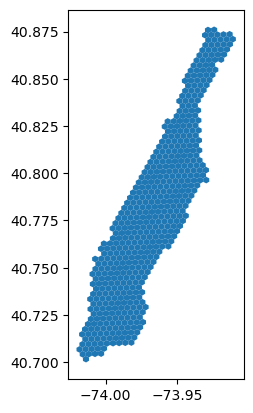

In [35]:
manhattan_hex.plot()

- raw 데이터 h3 index 매핑하기  

In [36]:
df["start_h3"] = df.apply(lambda x: h3.geo_to_h3(x['pickup_latitude'], x['pickup_longitude'], res2), axis=1)
df["dest_h3"] = df.apply(lambda x: h3.geo_to_h3(x['dropoff_latitude'], x['dropoff_longitude'], res2), axis=1)

print("Total start_h3:", len(df["start_h3"].unique()))
print("Total dest_h3:", len(df["dest_h3"].unique()))

Total start_h3: 3486
Total dest_h3: 7302


- datetime 변수 추출  

In [44]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
df["dropoff_datetime"] = pd.to_datetime(df["dropoff_datetime"])

df["pk_month"] = df["pickup_datetime"].dt.month
df["pk_hour"] = df["pickup_datetime"].dt.hour
df["dayofweek"] = df["pickup_datetime"].dt.weekday
df["weekend"] = np.where(df["dayofweek"]<=4,0,1)

df["pk_hour_cat"] = np.where((df["pk_hour"] >= 7) & (df["pk_hour"] <= 10), "AM_peak",
                             np.where((df["pk_hour"] >= 17) & (df["pk_hour"] <= 20), "PM_peak","Non_peak"))

- h3 index로 집계(count)  

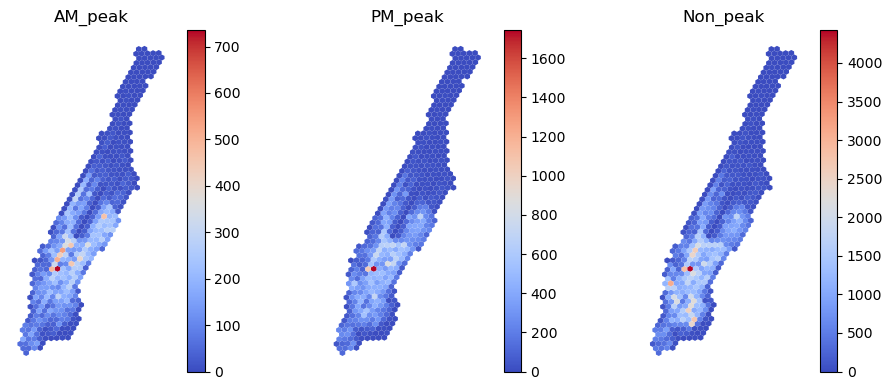

In [47]:
plt.figure(figsize=(10,4))
n=1
for m in ["AM_peak","PM_peak","Non_peak"]:
    sub_df = df[(df["pk_hour_cat"]==m) & (df["weekend"]==1)]
    sub_df = sub_df.groupby("start_h3").size().reset_index(name="cnt")
    result = manhattan_hex.merge(sub_df.rename({"start_h3":"hex_id"},axis=1), how='left', on="hex_id")
    result["cnt"] = result["cnt"].fillna(0)
    
    ax = plt.subplot(1,3,n)
    ax.set_axis_off()
    plt.title(m)
    a = result.plot(ax=ax,column='cnt', cmap='coolwarm', legend=True)
    n+=1
plt.tight_layout()
plt.show()

- 승차시간대에 따른 하차 위치 분포도 관찰  

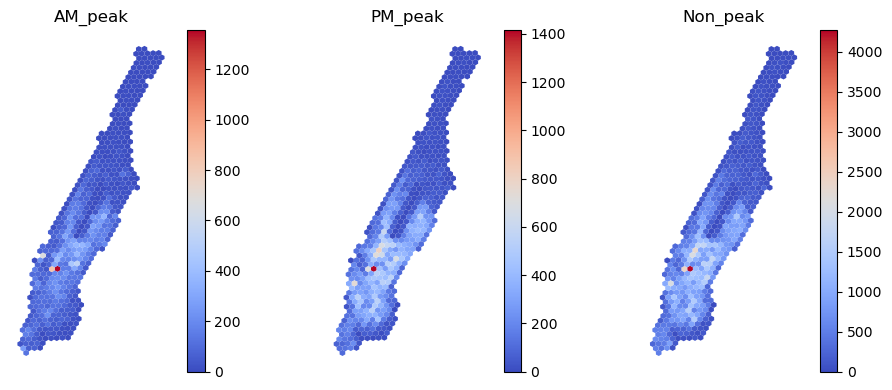

In [49]:
plt.figure(figsize=(10,4))
n=1
for m in ["AM_peak","PM_peak","Non_peak"]:
    sub_df = df[(df["pk_hour_cat"]==m) & (df["weekend"]==1)]
    sub_df = sub_df.groupby("dest_h3").size().reset_index(name="cnt")
    result = manhattan_hex.merge(sub_df.rename({"dest_h3":"hex_id"},axis=1), how='left', on="hex_id")
    result["cnt"] = result["cnt"].fillna(0)
    
    ax = plt.subplot(1,3,n)
    ax.set_axis_off()
    plt.title(m)
    a = result.plot(ax=ax,column='cnt', cmap='coolwarm', legend=True)
    n+=1
plt.tight_layout()
plt.show()

## kepler.gl in jupyter notebook

In [6]:
import pandas as pd
from keplergl import KeplerGl 

sample = pd.read_csv("dataset/sample.csv")
map = KeplerGl(height=500)
map.add_data(sample)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…